#### abstact
There are actually few studies based on rigorous statistics to verify whether the observations of code performance improvements are statistically significant or not. In this paper, we propose to use a methodology that analyzes the measured time of execution and that allows to perform a Speedup analysis to check the gain of an initial program with its optimization. We used data obtained by executing the arithmetic reduction algorithm, where the time taken to process the kernel in GPU was captured, and the significance of the samples is analyzed using the proposed methodology. As a result you get 51% acceleration with the algorithm optimized.

# Introduccción

El modelo de programacion en GPUs permite acelerar algoritmos paralelizando masivamente los procesos, si uno dobla el número de procesadores, el tiempo de ejecución debería reducirse a la mitad. Entonces, si se dobla el número de procesadores sucesivamente, entonces se debería acortar a la mitad el tiempo de ejecución exponensialmente. Todo programa consta de:

- Una o más porciones que no se pueden paralelizar
- Una o más porciones paralelizables

Esto es conocido como ley de Amdahl, la cual es un modelo matemático que describe la relación entre la aceleración esperada de la implementación paralela de un algoritmo y la implementación serial del mismo algoritmo.

Los tiempos de ejecución de un programa procesado en un procesador multi núcleo, como lo son las modernas GPUs, puede varias por diversos factores, algunos de estos factores son:

- Factores intrínsecos al programa paralela como: funciones de sincronización de los procesos, llamadas del sistema operativo, etc.
- Factores relacionados con el entorno de ejecución: máquina cargada, dirección de pila de inicio en la memoria, variable Frecuencia de la CPU, escala de voltaje dinámico, fijación de hilos en núcleos, etc.
- Factores relacionados con la microarquitectura del procesador: efectos de caché, ejecución fuera de orden, búsqueda automática de datos, ejecución especulativa, predicción de rama, etc.
- Factores relacionados con la medición del rendimiento: ruido de medición, imprecisión de la medición, etc.

Cualquiera de los factores anteriormente mencionados puede influenciar en las mediciones de rendimiento al momento de ejecutar el programa que se desea comparar, Esto significa que incluso cuando se trabaja en problemas grandes y altamente paralelos, su rendimiento será irregular, debido en gran parte a los residuos causados por la ley de Amdahl.

Una manera de medir el rendimiento de un programa es a través del speedup de un programa, speedup es definido como el proceso realizado para mejorar el rendimiento de un sistema que procesa un problema determinado, en otras palabras es la mejora en la velocidad de ejecución de una tarea ejecutada en dos arquitecturas similares con diferentes recursos, la cual se denota con la siguiente expresión matemática $S = \frac{L_{new}}{L_{old}}$, donde $L_{old}$ corresponde al tiempo de ejecución del programa antiguo y $L_{new}$ el tiempo de ejecución del programa nuevo. Estos tiempos pueden ser medidos con respecto al la observacion minima, maxima, media o mediana.


En este trabajo se tiene como principal objetivo responder a la pregunta de investigación: ¿podemos usar estadísticas para comparar entre los rendimientos de dos versiones del mismo programa? esta pregunta se busca responde a traves de un metología estadística en un caso practico con dos versiones del algoritmo de reducción aritmetica paralela implementada en GPU. Con el fin, de mejorar la reproducibilidad de los resultados experimentales, este trabajo presenta una metodología estadística rigurosa, para comprobar si dos muestras tienen diferencia significativas.

# Metodología

En este trabajo se utilizará la metodología propuesta por el trabajo realizado por Touati, quien propone un análisis estadístico riguroso para establecer si existe una diferencia significativa entre el speedup del tiempo de ejecución promedio, el speedup del tiempo de ejecución mínimo y el speedup de la mediana; los cuales son métricas utilizadas en la gran mayoría de artículos de computación de alto rendimiento. La figura 1 y 2 representa los diagramas de flujo que describen el algoritmo para utilizar la metodología propuesta.


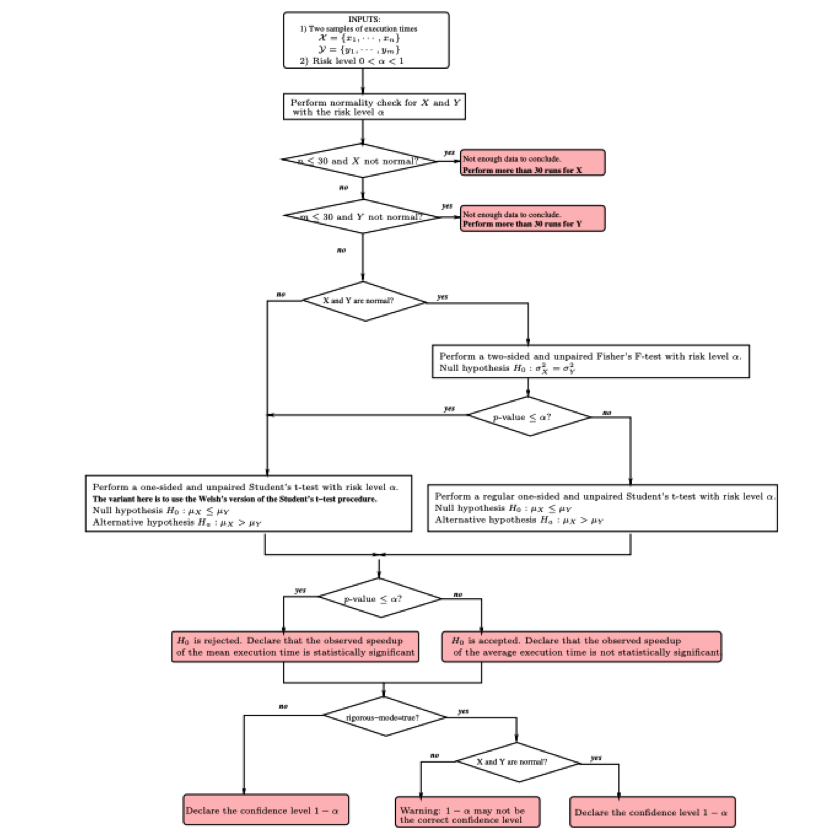

In [1]:
library(png)
img <- readPNG('figure1.png')
grid::grid.raster(img)

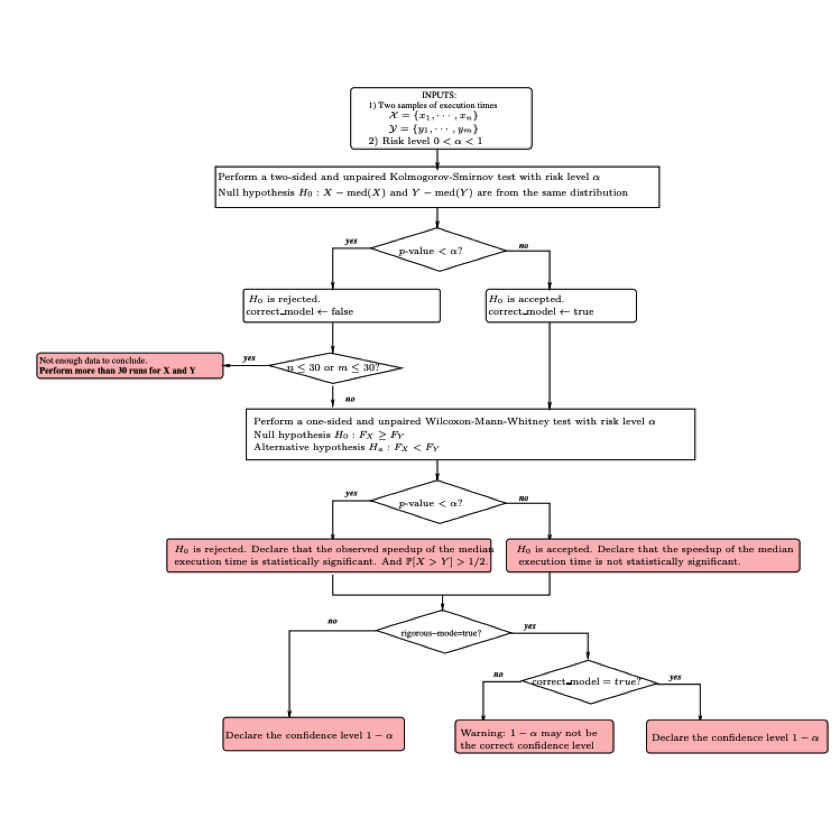

In [2]:
img2 <- readPNG('figure2.png')
grid::grid.raster(img2)

#### Requerimiento para la implementación:

Este trabajo es desarrollado en un Jupyter Notebook a modo de informe, utilizando el kernel de R y sus respectivas librerías para gráficar, y realizar las demostraciones con metódos estadísticos.

- Jupyter Notebook
- irKernel para jupyter
- ggplot2 libreria para R
- reshape libreria para R
- plyr libreria para R
- grid y gridExtra librerias de R

In [4]:
library(ggplot2)
library(reshape)
library(plyr)
library(gridExtra)
library(grid)

Generalmente, al realizar experimentos con optimización de código se experimentan haciendo múltiples observaciones, tanto de los tiempos de ejecución del código inicial (original) y el optimizado, para declarar una aceleración. En este caso particular, se tiene dos muestras de tamaño 100, donde cada observación de las muestras corresponden solo a los tiempos de ejecución (en segundos) obtenidos del fragmento del codigo el cual se paralelizó su proceso, luego de cada iteracion de los algoritmos de reducción aritmética paralela seleccionados, estos son implementados en GPU (desarrollados en los lenguajes de C y CUDA) para este trabajo, estos algoritmos son ejecutados en una GPU Nvidia Titan V.

In [5]:
old_layout <- read.csv('old_layout.csv', header=F, sep="\t")
old_layout <- old_layout$V1
new_layout <- read.csv('new_layout.csv', header=F, sep="\t")
new_layout <- new_layout$V1

# Análisis de la significancia estadística de los Speedup observados
Esta sección se divide en tres parte, la primera corresponde a un análisis previos de la entrada para ver si cumple con el tamaño y distribución adecuada, en la segunda parte corresponde a una prueba t de student donde comprobamos existe diferencia significancia de las nuestras muestras (siguiendo el diagrama de la figura 1), por ultimo, la tercera parte corresponde a un test de Wilcoxon-Mann-Whitney, para comprobar si la ejecución mediana el tiempo se ha reducido o no después de la transformación de un programa (siguiendo el diagrama de la figura 2).

## Speedup del tiempo promedio de ejecución observado
Se busca demostrar que podemos probar si $\mu_x > \mu_y$ y si $med(X) > med(Y)$, donde $\mu_x$ la media teórica de $X$ y $\mu_y$ la media teórica de $X$. Donde $X$ e $Y$ son las muestras de los tiempos de ejecución de los algoritmos orginal y la optmizacion respectivamente. Nosotros utilizamos la versión unilateral de la prueba t de Student y no la versión bilateral (ya que queremos verificar si la media de $X$ es mayor que la media de $Y$, no para probar si son simplemente distintas). Además, la observación $x_i \in X$ no corresponde a otra observación $y_j \in Y$, por lo que usamos la versión no pareada de la prueba t de Student.

### Tamaño necesario para la muestra X e Y
Si $X$ e $Y$ no corresponden a una distribucione gaussiana, se sabe que la prueba t de Student se mantiene robusta para muestras grandes (gracias al teorema del límite central), pero el riesgo calculado $\alpha$ no es exacto. Si $X$ e $Y$ no se distribuyen normalmente y son muestras pequeñas, no podemos concluir con la prueba t de Student. Como se ve en la figura, $X$ e $Y$ no se distribuyen normalmente, por lo que solo nos queda la pregunta de ¿es una muestra grande?, una muestra se considera grande cuando su tamaño excede de $30$ observaciones, tambien es conocido por ser arbitrario y utilizado para una simplificación numérica de la prueba de Student, por lo tanto utilizamos una muestra con 100 observaciones, para así tener una muestra que se considere grande, cumpliendo con los dos requisitos podemos proceder a realizar la prueba t de student.

In [6]:
ds <- as.data.frame(cbind(old_layout[1:100], new_layout[1:100]))
colnames(ds) <- c('old_layout', 'new_layout')
#ds

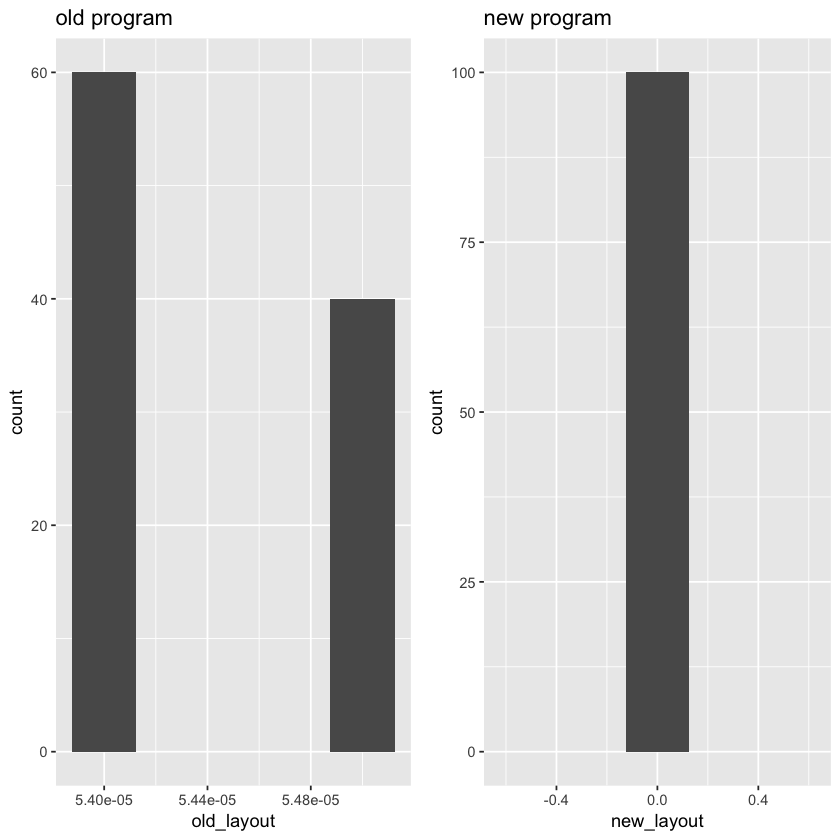

In [9]:
p1 <- ggplot(ds, aes(x=old_layout)) +
      geom_histogram(bins=5) +
      labs(title="old program")
p2 <- ggplot(ds, aes(x=new_layout)) +
      geom_histogram(bins=5) +
      labs(title="new program")
grid.arrange(p1, p2, ncol = 2)

### Pueba t de student
La prueba t de Welch es una adaptación de la prueba t de Student, la cual es más confiable cuando las dos muestras tienen varianzas desiguales, con $\sigma_X = 4.92366e{-07}$ y $\sigma_Y = 0$, respectivamente.

In [10]:
print(sd(ds$old_layout))
print(sd(ds$new_layout))

[1] 4.92366e-07
[1] 0


$H_0$, es la hipótesis nula que intentamos rechazar (para declarar un Speedup significativo) utilizando la prueba t de Student, es que $\mu_X \leq \mu_Y$, con una probabilidad de error igual a $\alpha$. Si la prueba rechaza esta hipótesis nula, entonces podemos aceptar $H_{\alpha}$ la hipótesis alternativa $\mu_X > \mu_Y$ con un nivel de confianza $1 - \alpha$. La prueba t de Student calcula un ${p-value}$, que es la probabilidad de error más pequeña para rechazar la hipótesis nula. Al igual que las hipóstesis, si $p-value \leq \alpha$, entonces la prueba t de Student rechaza $H_0$ con un nivel de riesgo inferior a $\alpha$. Por lo tanto podemos aceptar $H_a$ con un nivel de confianza $(1 - \alpha)$.


En resumen, tenemos las siguientes hipotesis:
$$H_{o}: \mu_X \leq \mu_Y$$
$$H_{\alpha}: \mu_X > \mu_Y$$

Por ultimo, procedemos a realizar el t de welch de las dos muestras, con un intervalo de confianza del $95\%$.

In [11]:
tt_ds <- t.test(old_layout, new_layout, conf.level = 0.95)
print(tt_ds)


	Welch Two Sample t-test

data:  old_layout and new_layout
t = 373.71, df = 99, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.83023e-05 1.84977e-05
sample estimates:
mean of x mean of y 
 5.44e-05  3.60e-05 



Siguiendo la ruta marcada en la figura 4, se obtiene como resultado de la prueba t de welch que *p-value* $< 2.2e{-16}$. Con lo cual, se puede concluir que $H_0$ es rechazado, por tener un p-value menor que $\alpha$ de $0.05$, **el Speedup observado del tiempo medio de ejecución es estadísticamente significativo**.

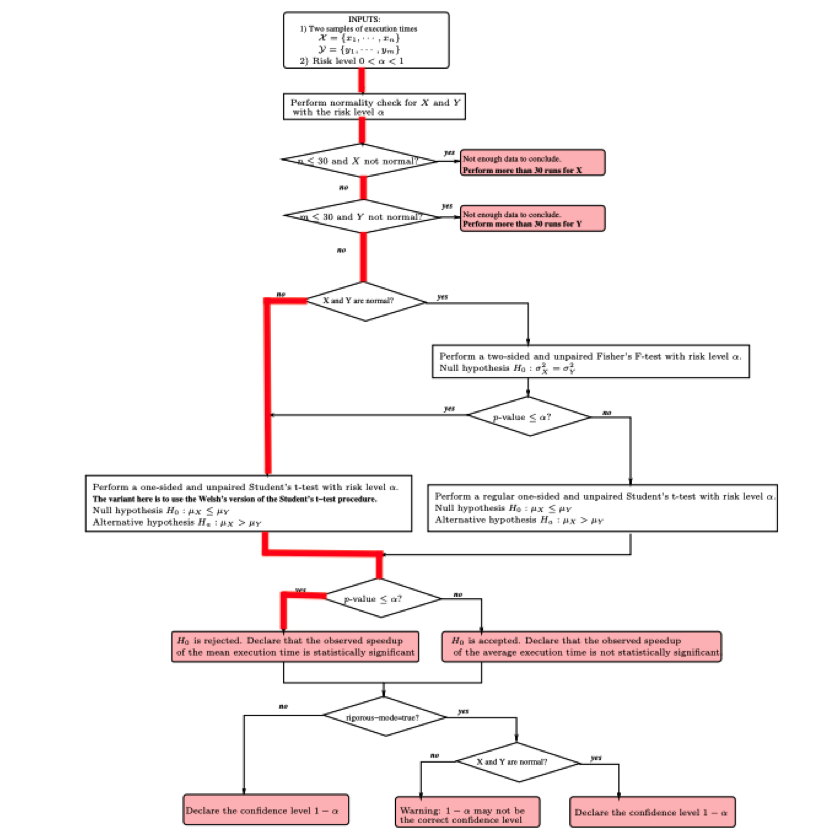

In [24]:
img4 <- readPNG('figure4.png')
grid::grid.raster(img4)

## Speedup del tiempo de ejecución mediana observado
Esta sección presenta la prueba de Wilcoxon-Mann-Whitney, una prueba estadística sólida para verificar si el tiempo de ejecución medio se ha reducido o no después de la optimización de un programa.

Como se hizo anteriormente con la prueba t de Student para comparar entre dos promedios, aquí queremos verificar si la mediana de $X$ es mayor que la mediana de $Y$, y si $P [X > Y] > 1/2$. Esto equivale a utilizar la variante unilateral de la prueba de Wilcoxon-Mann-Whitney. Además, dado que la observación $x_i$ de $X$ no corresponde a una observación $y_j$ de $Y$, usamos la versión no pareada de la prueba. $P [X > Y] > 1/2$ significa que hay más posibilidades de que una sola ejecución aleatoria del el programa optimizado será más rápido que una sola ejecución aleatoria del programa inicial.

### Prueba de Kolmogorov-Smirnov
La prueba de Kolmogórov-Smirnov es una prueba no paramétrica que determina la bondad de ajuste de dos distribuciones de probabilidad entre sí.

Con Kolmogórov-Smirnov se busca probar la hipótesis nula $H_0$ de la igualdad de las distribuciones de las variables $X - med (X)$ e $Y - med (Y)$, utilizando la prueba de dos muestras de Kolmogorov-Smirnov aplicada a las observaciones $x_i - med (X)$ e $y_j - med (Y)$. La prueba de Kolmogorov-Smirnov calcula un valor de p: si $p-value < \alpha$, entonces $H_0$ se rechaza con un nivel de riesgo $\alpha$. Es decir, $X$ e $Y$ no satisfacen el modelo matemático requerido por la prueba de Wilcoxon-Mann-Whitney, la hipotesis utilizada en la prueba es:

$$H_0 : X - med (X) \land Y - med (Y)$$

Cuando hay ligaduras o ties, la función ks.test() no es capaz de calcular el p-value exacto por lo que devuelve una aproximación asumiendo que se distribuye de forma ~ normal. En estos casos, o cuando los tamaños muestrales son mayores de $20$ y se quiere la aproximación por la normal. Sabiendo esto, se obtiene un p-value < 2.2e-16 de la prueba de Kolmogorov-Smirnov, por lo cual se rechaza la hipótesis nula, por ser inferior al $\alpha$ de $0.05$ establecido. Es decir, las muestras $X$ e $Y$ no satisfacen el modelo matemático requerido por la prueba de Wilcoxon-Mann-Whitney.

In [13]:
ks <- ks.test(ds$old_layout, 
              ds$new_layout)
print(ks)

Warning message in ks.test(ds$old_layout, ds$new_layout):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  ds$old_layout and ds$new_layout
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided



### Prueba de Wilcoxon-Mann-Whitney
La prueba de Wilcoxon-Mann-Whitney, es una prueba no paramétrica aplicada a dos muestras independientes. Esta prueba corresponde a la versión no paramétrica de la habitual prueba t de Student. Contrariamente a la prueba t de Student, la prueba de Wilcoxon-Mann-Whitney no asume ninguna distribución específica para $X$ e $Y$.

Como se a mencionado antes, las muestras no satisfacen al modelo matemático, la prueba Wilcoxon-Mann-Whitney permite ser usada con muestras suficientemente grandes ($n \geq 30$), pero es posible que no se mantenga el nivel de riesgo esperado.

Se tiene como hipótesis para la prueba de Wilcoxon-Mann-Whitney:

$$H_0 : F_X \geq F_Y$$
$$H_{\alpha} : F_X < F_Y$$

Lo que significa que X tiende a ser mayor que Y, Si $p-valor < \alpha$, entonces $H_0$ es rechazado. Es decir, admitimos $H_{\alpha}$ con un nivel de confianza $1 − \alpha$: $F_X > F_Y$. Esto equivale a declarar que la aceleración observada de los tiempos de ejecución medios es estadísticamente significativa, $med(X) > med(Y)$ con un nivel de confianza $1 - \alpha$ y $P [X> Y]> 1/2$. Si la hipótesis nula no se rechaza, entonces la aceleración observada de la mediana no se considera estadísticamente significativa.

In [14]:
wilcox.test(x = ds$old_layout, 
            y = ds$new_layout, 
            alternative = "two.sided", 
            mu = 0,
            paired = FALSE, 
            conf.int = 0.95)


	Wilcoxon rank sum test with continuity correction

data:  ds$old_layout and ds$new_layout
W = 10000, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 1.8e-05 1.9e-05
sample estimates:
difference in location 
               1.8e-05 


Siguiendo la ruta marcada en la figura 5, se obtiene como resultado de la prueba Wilcoxon-Mann-Whitney que *p-value* $ < 2.2e{-16}$. Con lo cual, se puede concluir que $H_0$ es rechazado, debido a que es menor que $\alpha$ de $0.05$, **el Speedup observado del tiempo mediano de ejecución es estadísticamente significativo**.

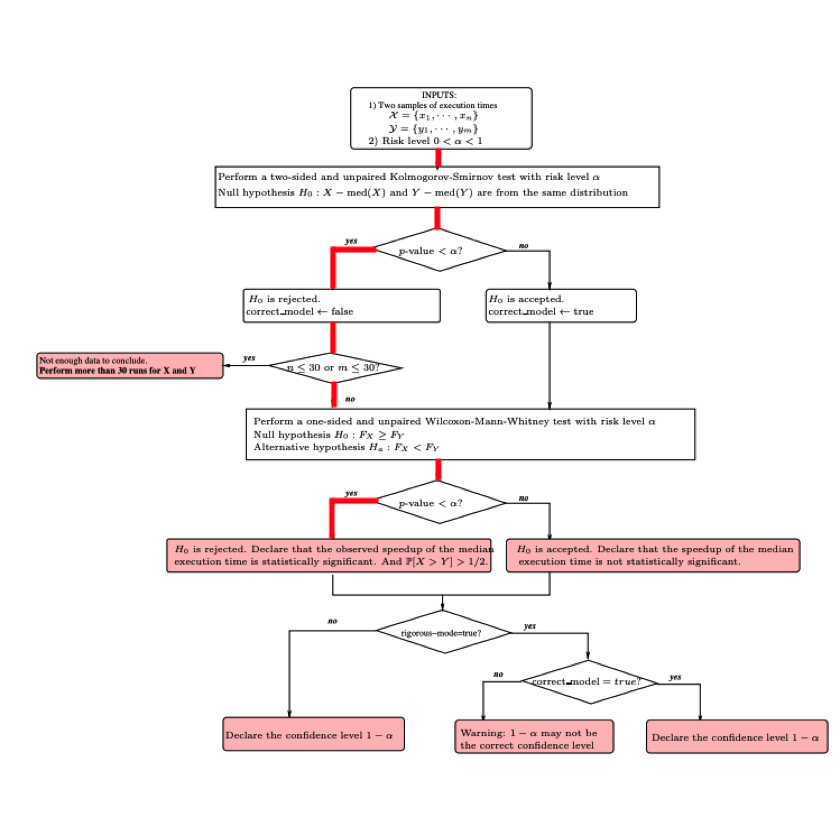

In [25]:
img5 <- readPNG('figure5.png')
grid::grid.raster(img5)

# Evaluación de la proporicion de la aceleración del benchmark
En este tabajo se realizarón las evaluaciones del rendimiento solo de la porción paralelizable (GPU kernel) del algoritmo de reducción aritmetica paralela. 

Especificaciones del entorno de evaluación:
- CPU: Intel(R) Core(TM) i7-6950X CPU @ 3.00GHz
- GPU: NVIDIA Corporation GV100 [TITAN V]
- RAM: 128GB
- OS: Arch-Linux

De los tiempos de ejecución medios y meadianos, obtenemos la fracción de aceleración de un programa a sobre un programa b, tambien llamado como Speedup:

$$ S = \frac{a}{b}$$

- Speedup obtenido usando media: 1.51  
- Speedup obtenido usando mediana: 1.5

Las aceleraciones observadas son casi idénticas, porque en este conjunto de experimentos, la mediana observada y los tiempos de ejecución medios de cada punto de referencia fueron casi idénticos, con dos dígitos de precisión existe diferencia.

In [23]:
print(mean(ds$old_layout)/mean(ds$new_layout))
print(median(ds$old_layout)/median(ds$new_layout))

[1] 1.511111
[1] 1.5


# Conclusiones
Respondiendo a la pregunta de investigación, podemos decir que “si”, es posible aplicar metodologías estadísticas para comparar entre los rendimientos de dos versiones del mismo programa, como es comprobado con la metodología propuesta en el algoritmo de reducción aritmética paralela, donde se comprobo que no existen diferencias significativas entre las muestras obtenidas, en ninguno de los dos casos estudiados. 

Se obtiene un 51% de aceleración del algoritmo optimizado con respecto de la versión inicial, utilizando tanto la media como la mediana, por lo que esta claro que no existe diferencia entre utilizar la media o mediana en este caso. 

Se puede observar, que a pesar de que las muestras no se distribuyan normalmente, es posible utilizar la prueba t de suden y la prueba de Wilcoxon-Mann-Whitney si las muestras son lo suficientemente grande ($n > 30$), en este caso se utilizan muestras con 100 observaciones.

De los resultados del análisis de Kolmogorov-Smirnov se obtiene que la hipótesis $H_0$ es rechazada, esto significa que el modelo utilizado no es apto para realizar una prueba de Wilcoxon-Mann-Whitney, por ello es necesario utilizar una muestra que se considere grande.

## Referencias
https://hal.inria.fr/hal-00764454/document

https://hal.inria.fr/inria-00443839v2/document

https://bit.ly/2Qx9nu4

#### By Roberto Carrasco